In [14]:
# 查看当前挂载的数据集目录
!ls /home/aistudio/

42184.ipynb  data  GaitDatasetA-silh  hog-svm.ipynb  svm_data.dat  work


In [47]:
# 查看个人持久化工作区文件
!ls /home/aistudio/work/

# 基于GEI的HOG特征，使用SVM分类器分类步态识别

采用中科院自动化所GaitDatasetA-silh小型步态识别数据集进行实验分析

将数据集每人序列帧图像平均分为两部分，一部分为训练集，一部分为测试集

对行人二值化序列帧图像求平均得到GEI步态能量图，再采用OpenCV内置HOGDescriptor提取出GEI的HOG特征值，利用HOG特征训练SVM分类器，最终采用模型进行预测。识别率达到99.1667%

## 图片预处理
对人体区域进行裁剪，将人体对称轴放于图片中央。

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
%matplotlib inline


def cut_img(img, T_H, T_W):
    # 获得最高点和最低点
    y = img.sum(axis=1)
    y_top = (y != 0).argmax(axis=0)
    y_btm = (y != 0).cumsum(axis=0).argmax(axis=0)
    img = img[y_top:y_btm + 1, :]
    # 如果高比宽要大，用高计算 resize 的比例
    _r = img.shape[1] / img.shape[0]
    _t_w = int(T_H * _r)
    img = cv.resize(img, (_t_w, T_H), interpolation=cv.INTER_CUBIC)
    # 获得人的对称轴
    sum_point = img.sum()
    sum_column = img.sum(axis=0).cumsum()
    x_center = -1
    for i in range(sum_column.size):
        if sum_column[i] > sum_point / 2:
            x_center = i
            break
    h_T_W = int(T_W / 2)
    left = x_center - h_T_W
    right = x_center + h_T_W
    if left <= 0 or right >= img.shape[1]:
        left += h_T_W
        right += h_T_W
        _ = np.zeros((img.shape[0], h_T_W))
        img = np.concatenate([_, img, _], axis=1)
    img = img[:, left:right]
    return img

# GEI步态能量图

In [3]:
def get_GEI(imgs):
    GEI = (imgs[0]/255).astype("uint8")
    for img in imgs[1:]:
        GEI += (img/255).astype("uint8")
    GEI = GEI/len(imgs)

    return (GEI*255).astype("uint8")
    # GEI = imgs[0].astype("uint8")
    # for img in imgs[1:]:
    #     GEI += img.astype("uint8")
    # GEI = GEI/len(imgs)

    # return (GEI).astype("uint8")

# 取HOG特征
采用opencv封装的HOGDescriptor进行HOG特征计算

block大小为8 * 8
cell大小为8 * 8
每个block 取 9 个 bin

In [4]:

SZ=20
bin_n = 16 # Number of bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR
def get_Hog(img):
    # gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    # gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    # mag, ang = cv.cartToPolar(gx, gy)
    # mags.append(mag)
    # angs.append(ang)
    # bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    # bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    # mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    # hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    # hist = np.hstack(hists)     # hist is a 64 bit vector
    # return hist
    winSize = (img.shape[1], img.shape[0])      # winSize = (64,64)
    blockSize = (8,8)                               # blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv.HOGDescriptor(winSize,blockSize,blockStride,
                  cellSize,nbins,derivAperture,
                  winSigma,histogramNormType,L2HysThreshold,
                  gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (8,8)
    locations = [] # (10, 10)# ((10,20),)
    hist = hog.compute(img,winStride,padding,locations)
    # hist.dtype = np.float64
    return hist

# 读取GaitDatasetA-silh数据集文件

In [5]:
roots = "/home/aistudio/GaitDatasetA-silh/"
cells = []
labels = []
label = os.listdir(roots)
print(label)
# print(label)
for dir_ in label:
    dirs = os.listdir(roots + dir_)
    for dir__ in dirs:
        # print(dir_ + "_" + dir__)
        for root_,dirs_,files in os.walk(roots + dir_ + "/" + dir__):
            # print(root_)
            imgs = []
            for file in files:
                srcImg = cv.imread(root_ + "/" + file,0)
                imgs.append(cut_img(srcImg,128,128))
            cells.append(imgs)
        labels.append(dir_ + "_" + dir__)
print(labels)

['hy', 'ml', 'zjg', 'fyc', 'zl', 'lsl', 'wq', 'zdx', 'rj', 'lqf', 'xch', 'yjf', 'zyf', 'syj', 'zc', 'wl', 'xxj', 'ljg', 'nhz', 'wyc']
['hy_00_2', 'hy_45_1', 'hy_45_3', 'hy_90_4', 'hy_00_4', 'hy_00_3', 'hy_90_1', 'hy_45_4', 'hy_00_1', 'hy_90_3', 'hy_90_2', 'hy_45_2', 'ml_00_2', 'ml_45_1', 'ml_45_3', 'ml_90_4', 'ml_00_4', 'ml_00_3', 'ml_90_1', 'ml_45_4', 'ml_00_1', 'ml_90_3', 'ml_90_2', 'ml_45_2', 'zjg_00_2', 'zjg_45_1', 'zjg_45_3', 'zjg_90_4', 'zjg_00_4', 'zjg_00_3', 'zjg_90_1', 'zjg_45_4', 'zjg_00_1', 'zjg_90_3', 'zjg_90_2', 'zjg_45_2', 'fyc_00_2', 'fyc_45_1', 'fyc_45_3', 'fyc_90_4', 'fyc_00_4', 'fyc_00_3', 'fyc_90_1', 'fyc_45_4', 'fyc_00_1', 'fyc_90_3', 'fyc_90_2', 'fyc_45_2', 'zl_00_2', 'zl_45_1', 'zl_45_3', 'zl_90_4', 'zl_00_4', 'zl_00_3', 'zl_90_1', 'zl_45_4', 'zl_00_1', 'zl_90_3', 'zl_90_2', 'zl_45_2', 'lsl_00_2', 'lsl_45_1', 'lsl_45_3', 'lsl_90_4', 'lsl_00_4', 'lsl_00_3', 'lsl_90_1', 'lsl_45_4', 'lsl_00_1', 'lsl_90_3', 'lsl_90_2', 'lsl_45_2', 'wq_00_2', 'wq_45_1', 'wq_45_3', 'wq_

# 将数据分为训练集与测试集两部分

In [6]:
train_cells = []
test_cells = []
for cell in cells:
    train_cells.append(cell[0:-1:2])
    test_cells.append(cell[1:-1:2])
    # train_cells.append(cell[:len(cell)//2])
    # test_cells.append(cell[len(cell)//2:])

# 对训练集构建基于GEI的HOG特征
将训练集数据读入，首先提取GEI步态能量图

然后对GEI提取HOG特征，每张GEI的HOG特征为20736 * 1大小

标记240个训练数据，按照人进行编号，每个人12组数据，共20人

输出折线图横轴为HOG数据编号，共240个；纵轴为对应人员编号，共20个

(240, 20736, 1)
(240, 1)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
   2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
   4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
   6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
   8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
  12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
  14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
  16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17
  18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19]]


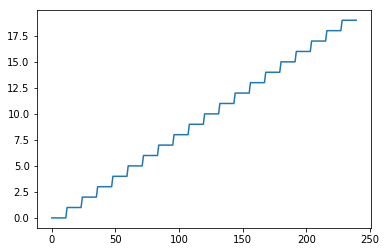

In [7]:
traingeis = []
for train_cell in train_cells:
    traingeis.append(get_GEI(train_cell))
    
trainhogs = []
for traingei in traingeis:
    trainhog = get_Hog(traingei)
    trainhogs.append(trainhog)
trainData = np.float32(trainhogs).reshape(-1,20736,1)
print(trainData.shape)
responses = np.repeat(np.arange(20),12)[:,np.newaxis]
print(responses.shape)
print(responses.T)
plt.plot(responses)
plt.show()

# 对测试集构建基于GEI的HOG特征

与训练集处理方式相同，每个HOG特征为20736 * 1大小

In [8]:
testgeis = []
for test_cell in test_cells:
    testgeis.append(get_GEI(test_cell))
testhogs = []
for testgei in testgeis:
    testhog = get_Hog(testgei)
    testhogs.append(testhog)
testData = np.float32(testhogs).reshape(-1,20736,1)
print(testData.shape)

(240, 20736, 1)


# 采用线性内核函数训练OpenCV内置SVM分类器

In [21]:
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(5.35)
svm.setGamma(3.58)
svm.train(trainData,cv.ml.ROW_SAMPLE,responses)
svm.save('svm_data.dat')

# 使用训练好的模型进行预测
打印预测结果

采用折线图输出预测结果，横纵坐标同训练集标记类型

实验结果识别率达到99.1667%

[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
   2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
   4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
   6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
   8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
  12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
  14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
  16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17
  18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19]]


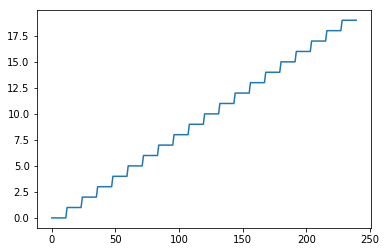

100.0


In [22]:
result = svm.predict(testData)[1].astype("int")
print(result.T)
plt.plot(result)
plt.show()
mask = result==responses
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

# 输出测试集与训练集对用HOG,GEI直观对比

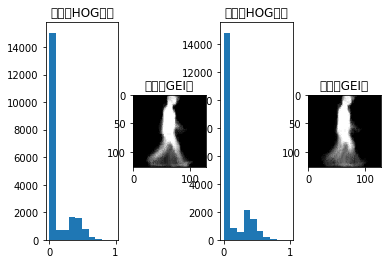

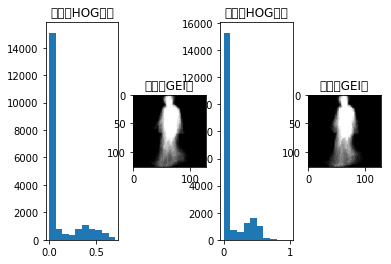

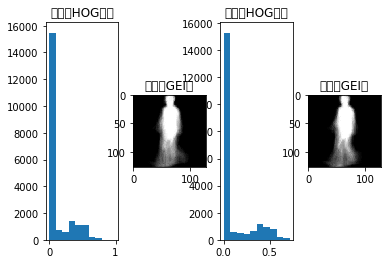

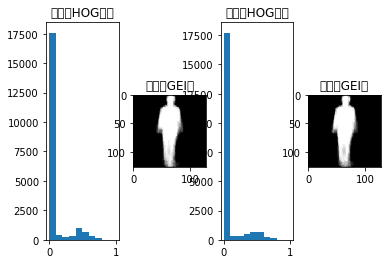

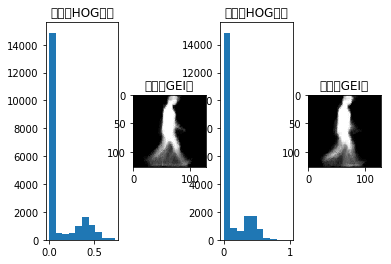

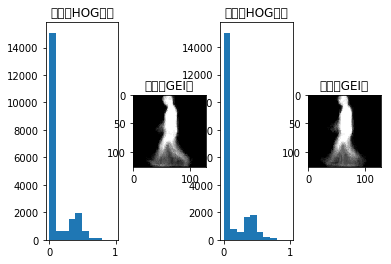

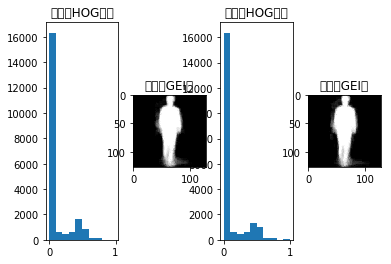

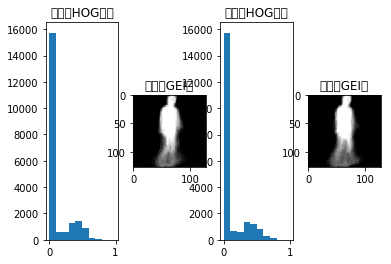

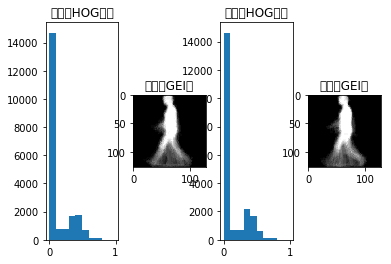

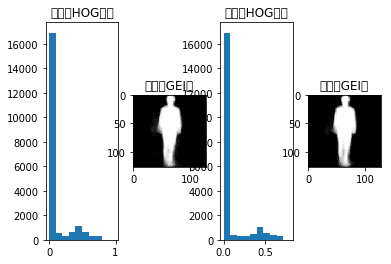

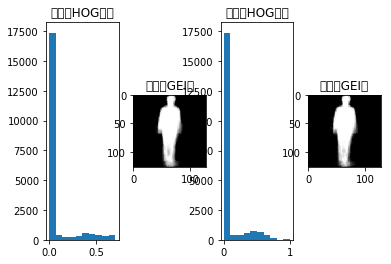

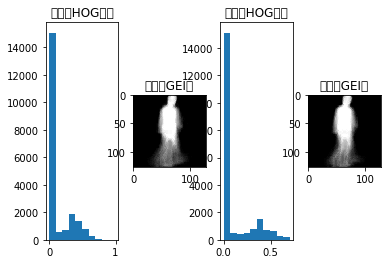

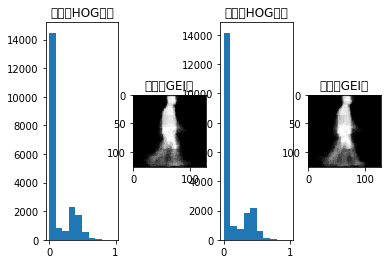

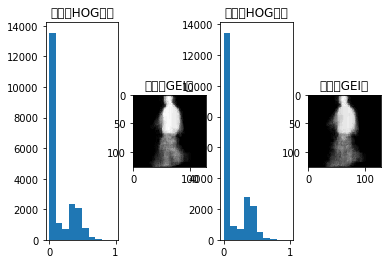

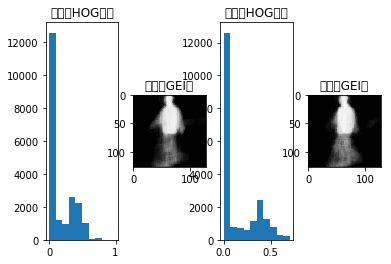

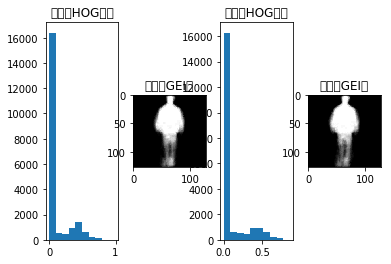

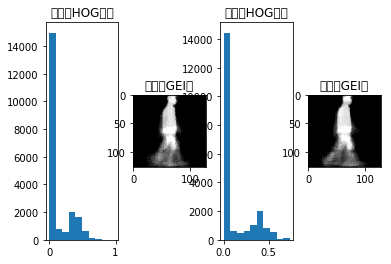

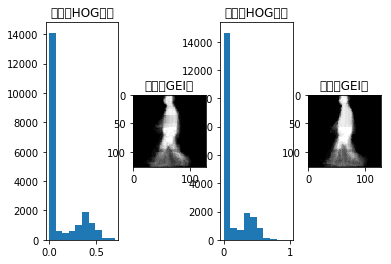

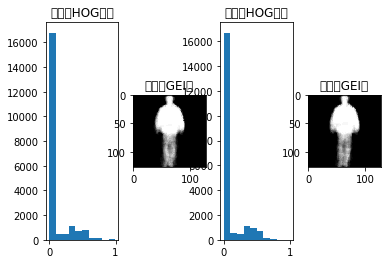

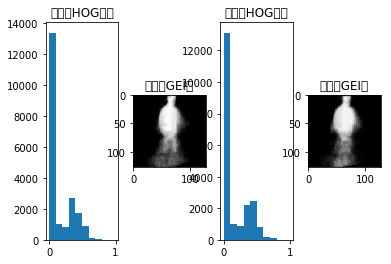

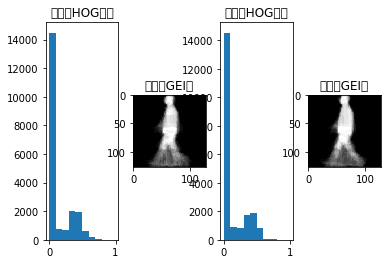

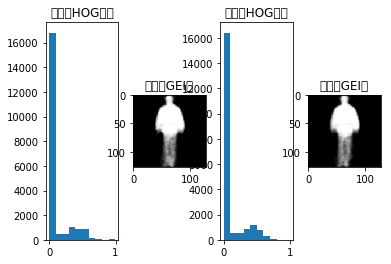

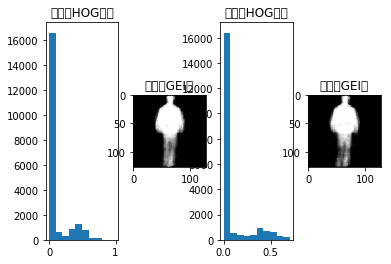

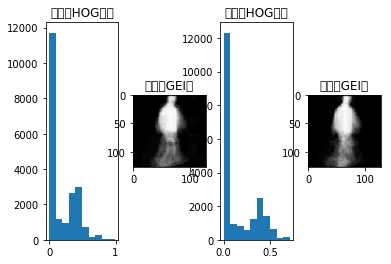

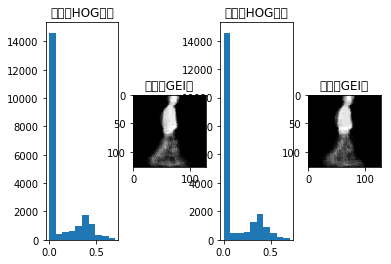

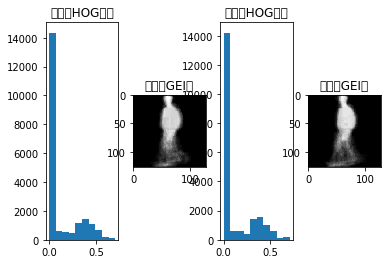

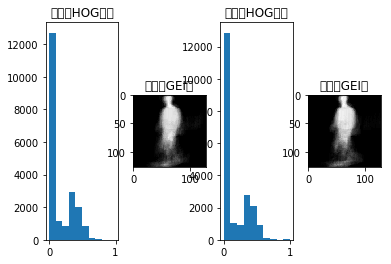

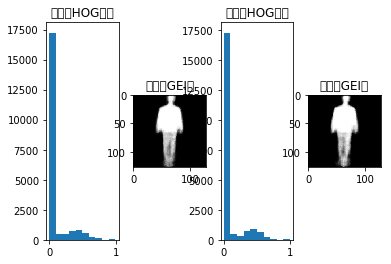

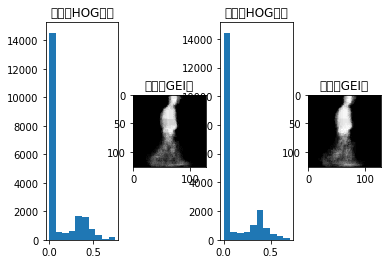

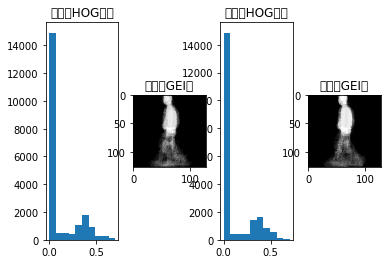

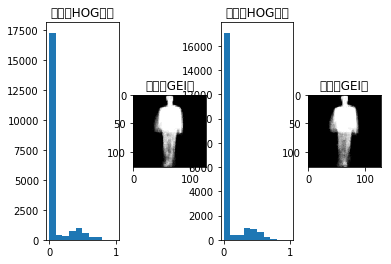

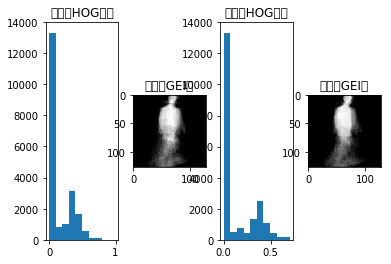

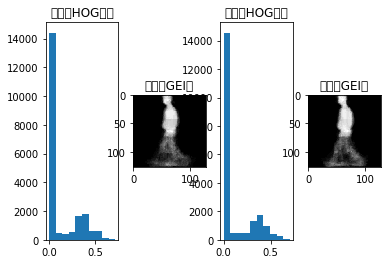

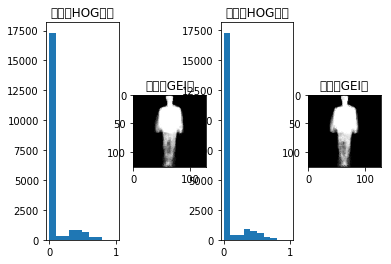

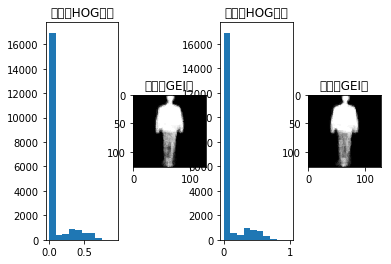

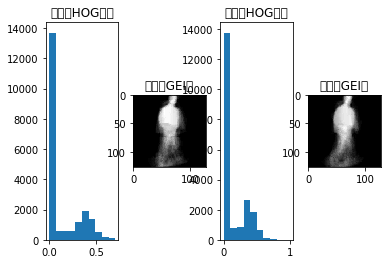

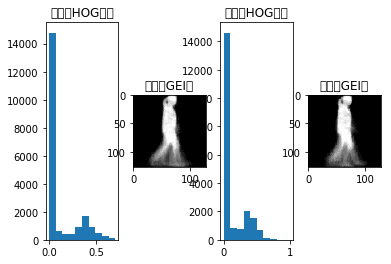

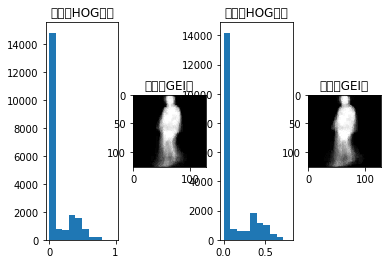

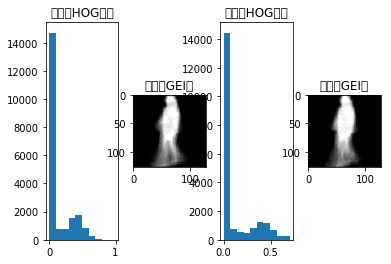

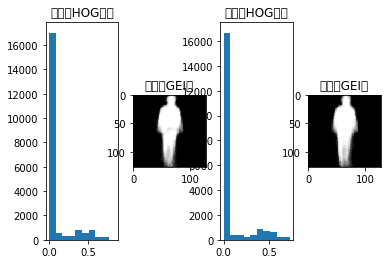

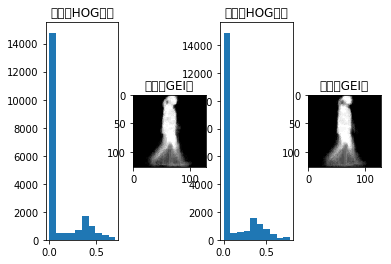

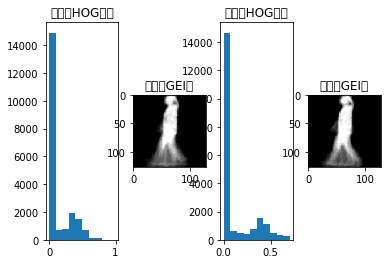

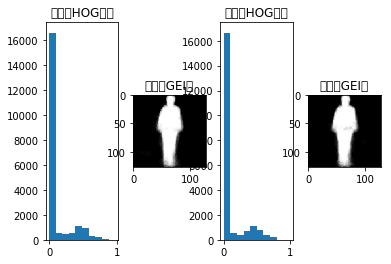

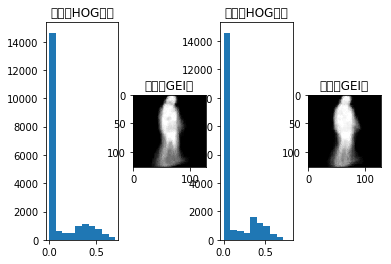

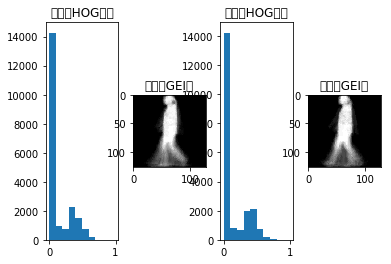

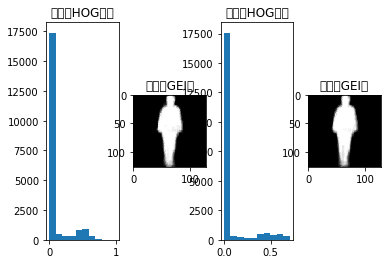

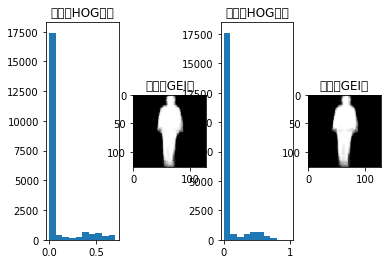

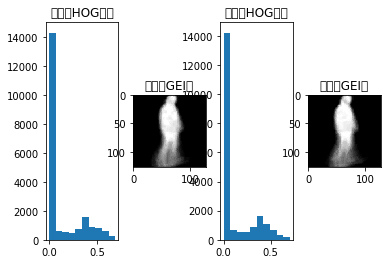

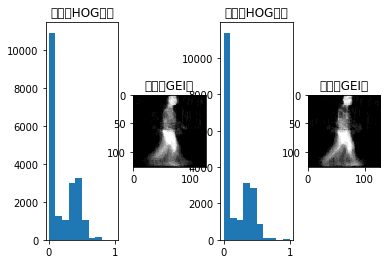

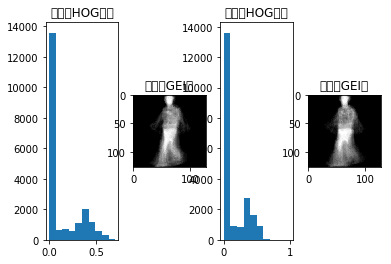

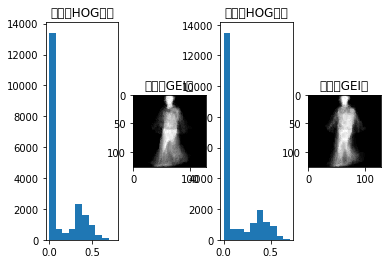

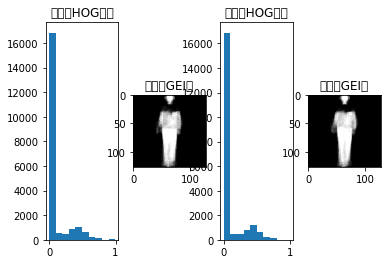

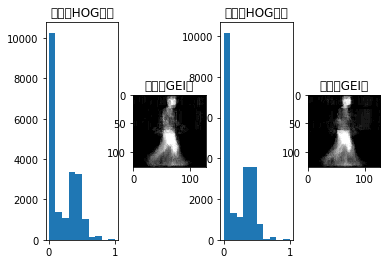

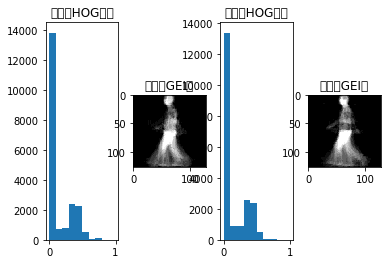

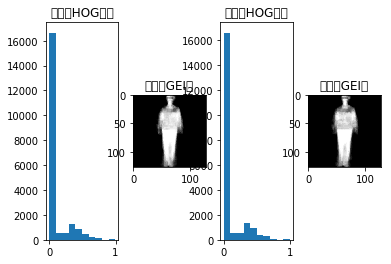

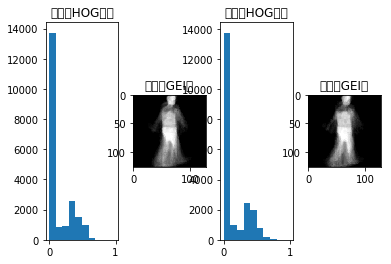

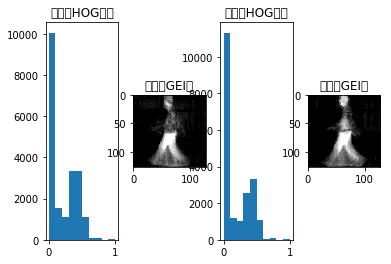

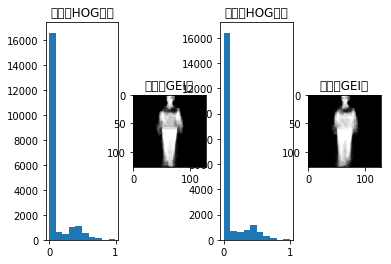

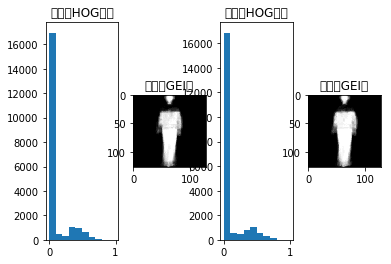

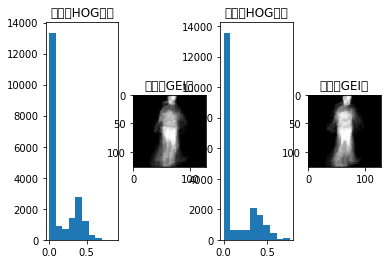

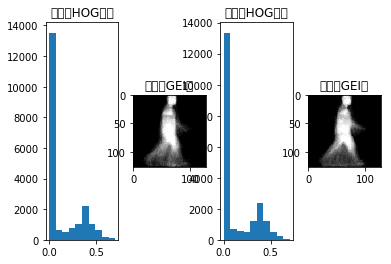

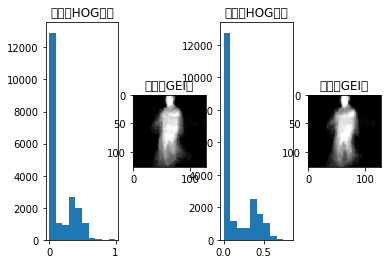

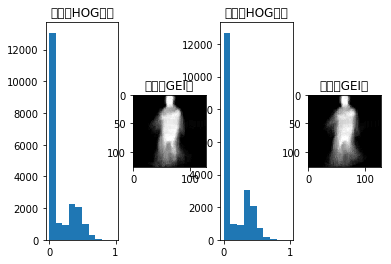

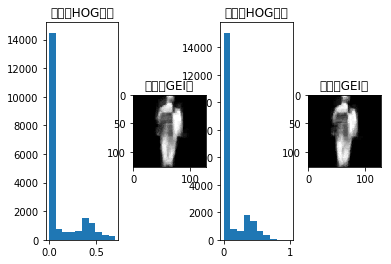

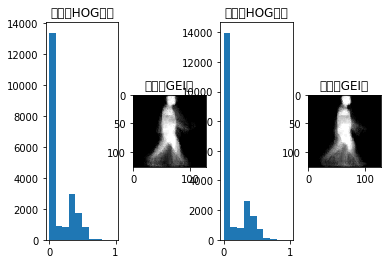

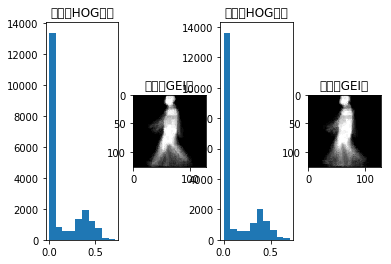

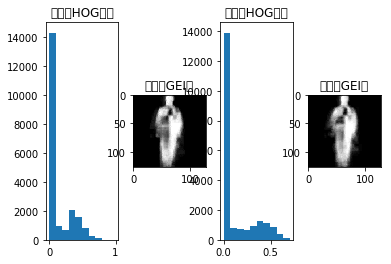

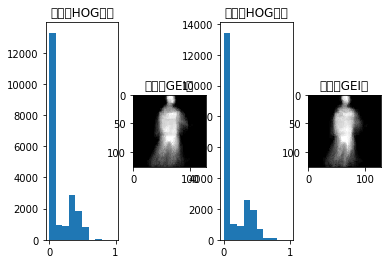

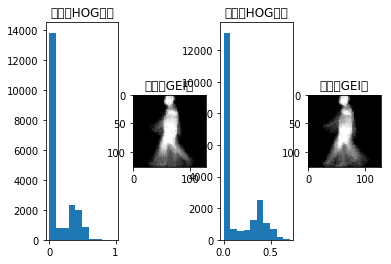

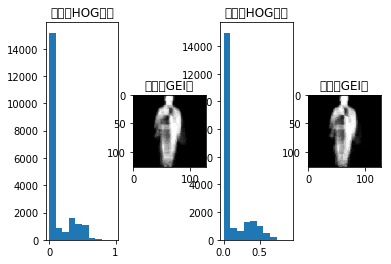

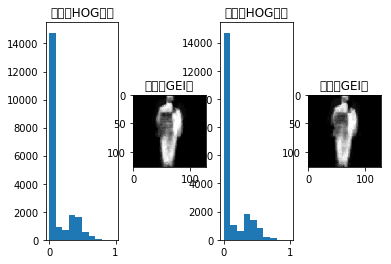

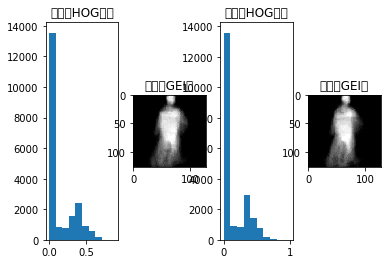

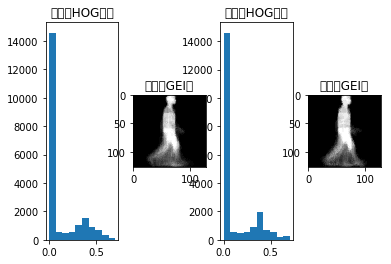

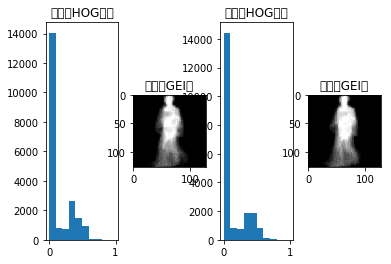

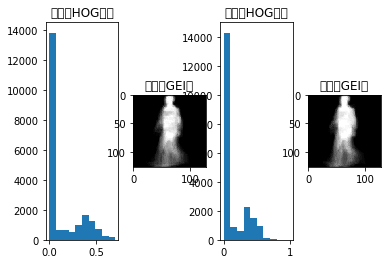

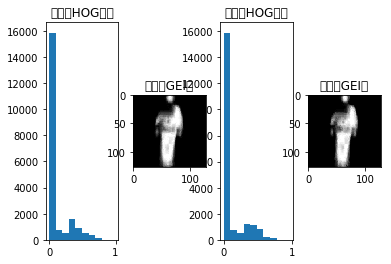

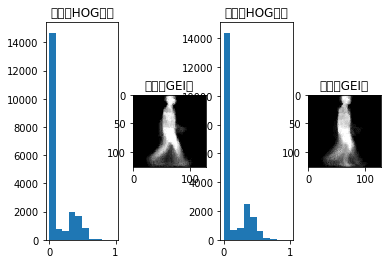

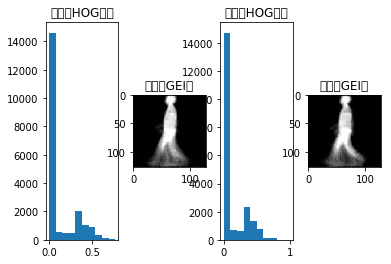

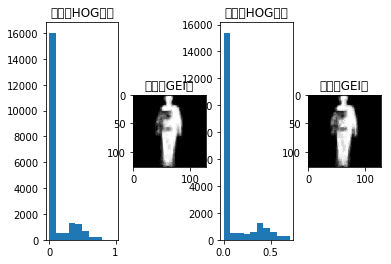

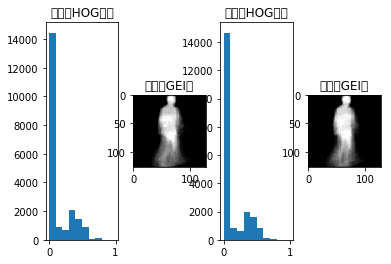

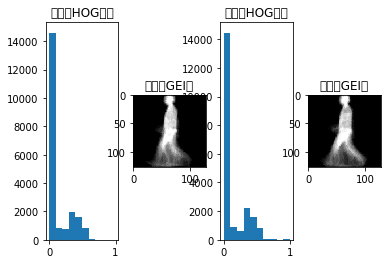

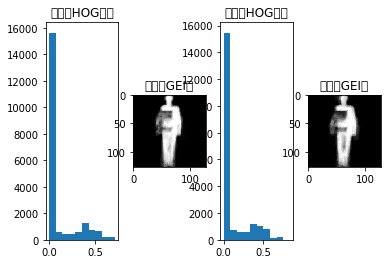

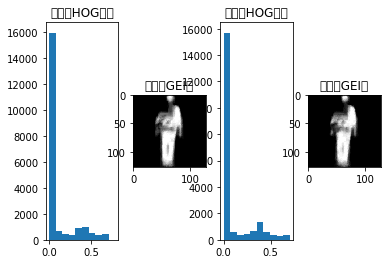

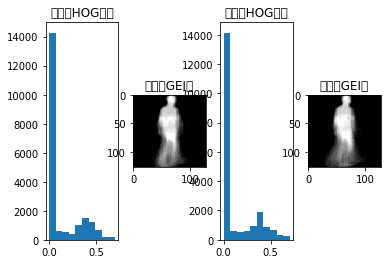

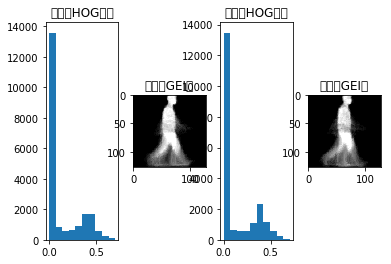

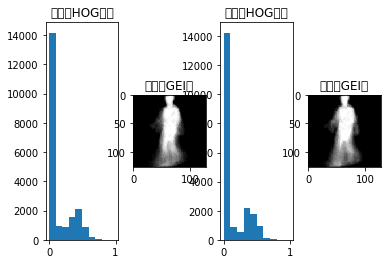

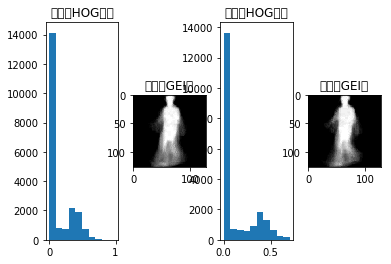

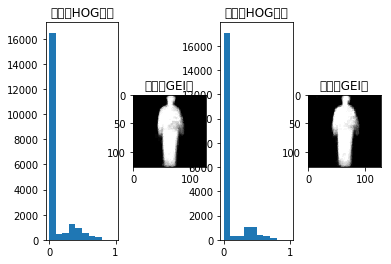

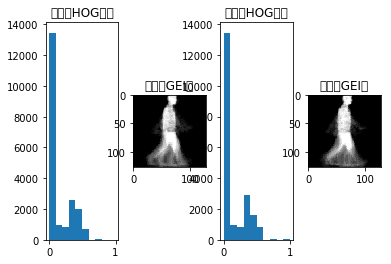

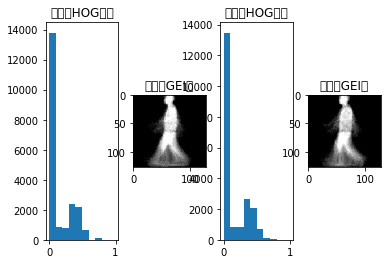

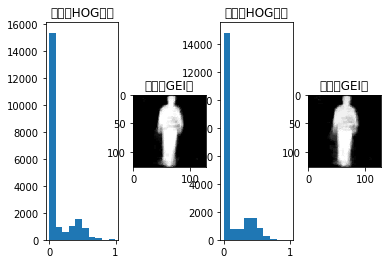

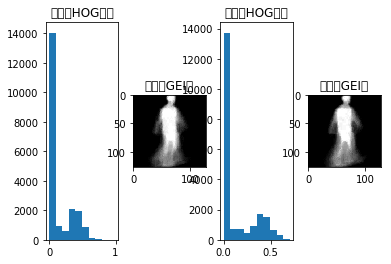

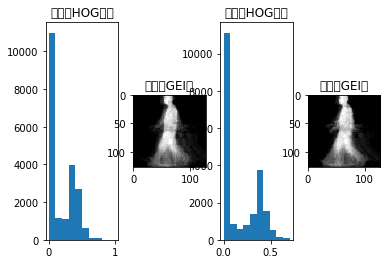

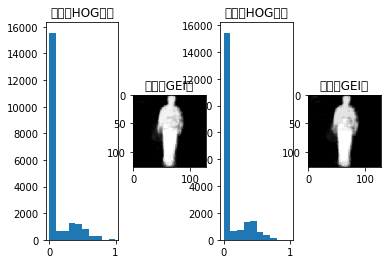

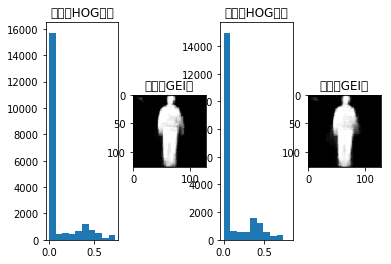

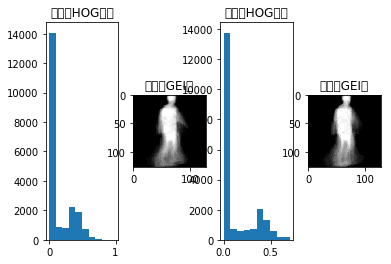

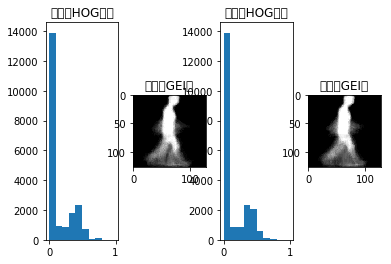

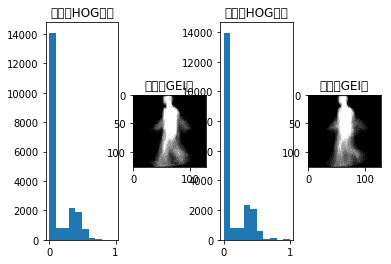

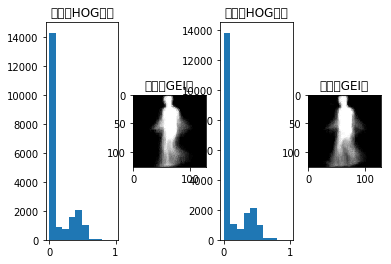

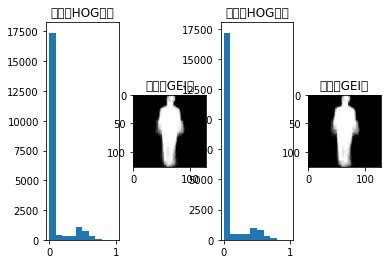

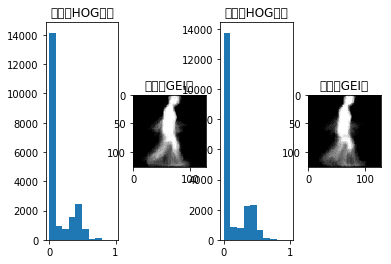

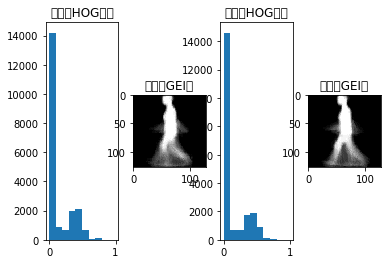

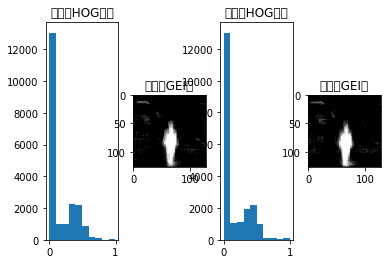

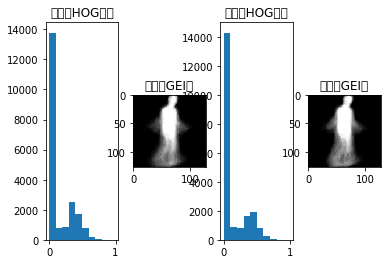

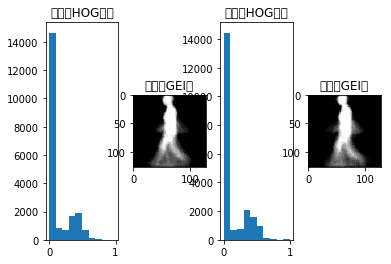

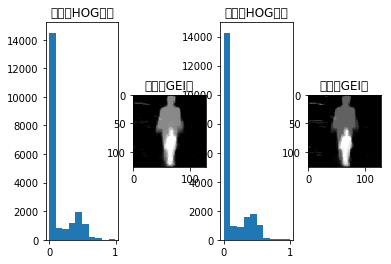

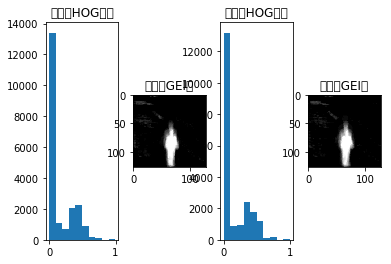

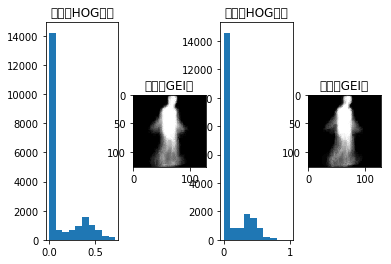

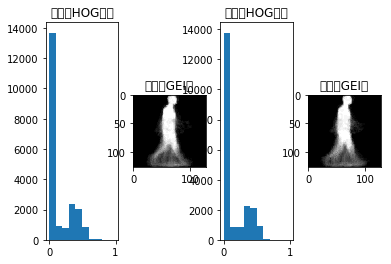

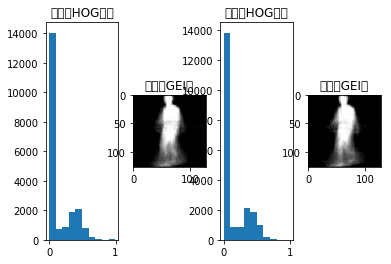

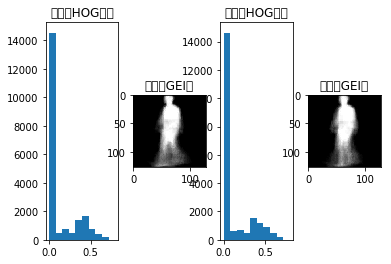

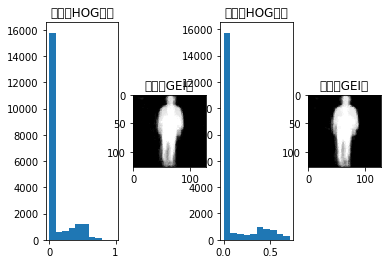

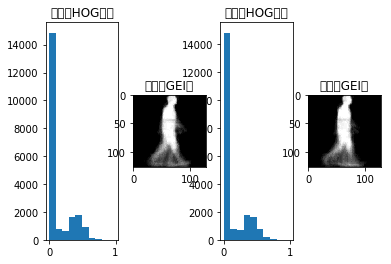

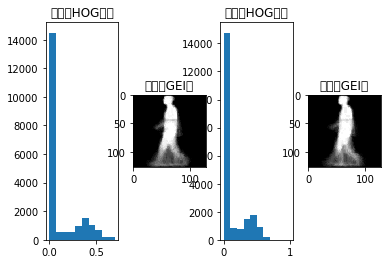

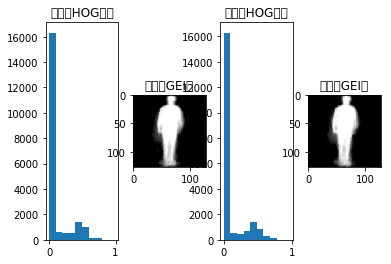

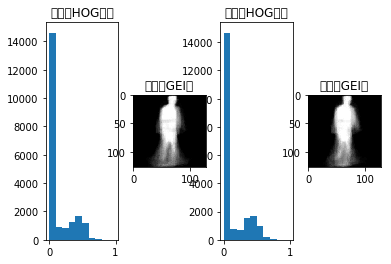

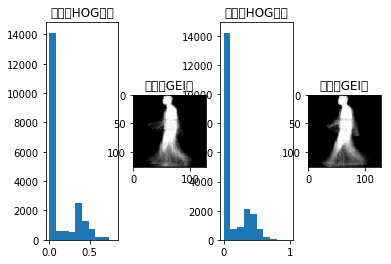

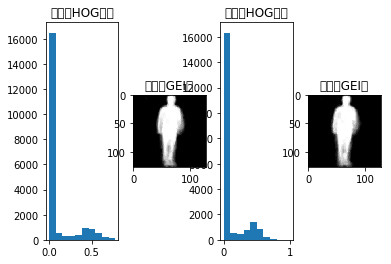

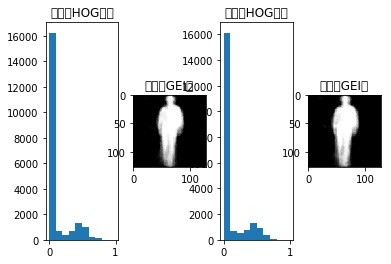

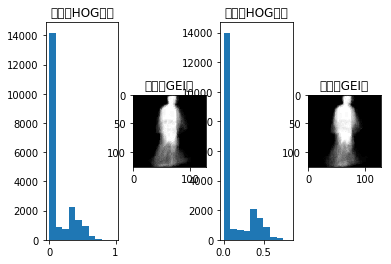

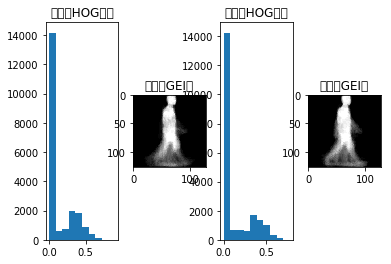

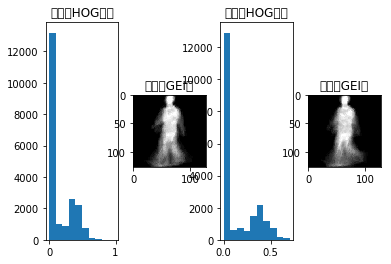

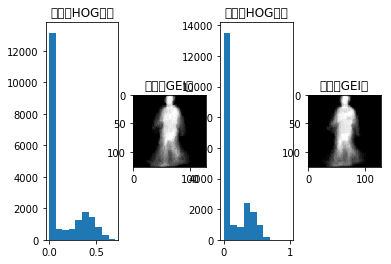

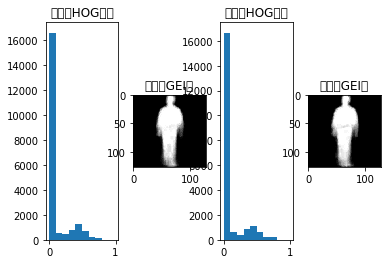

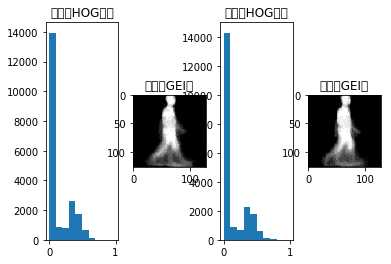

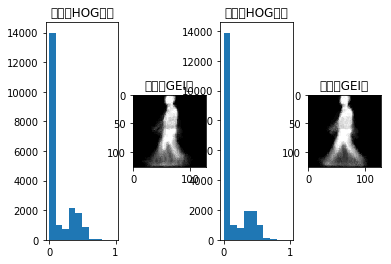

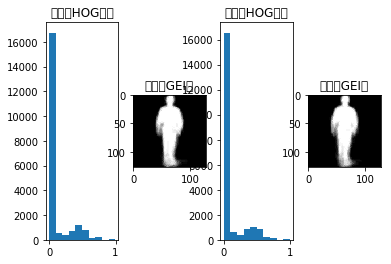

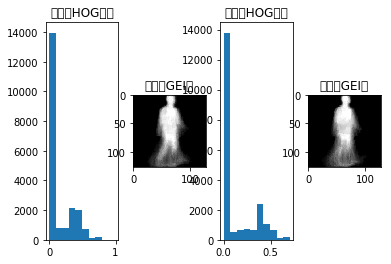

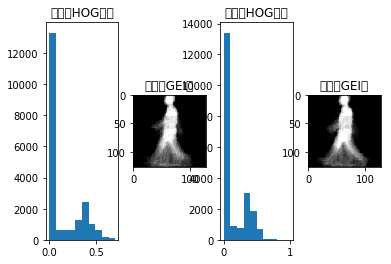

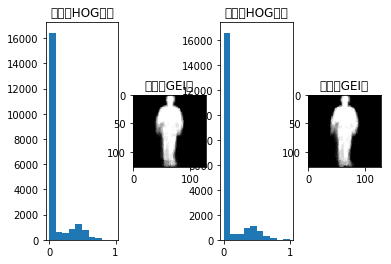

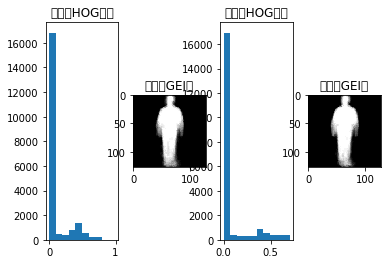

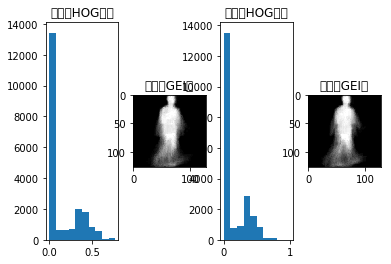

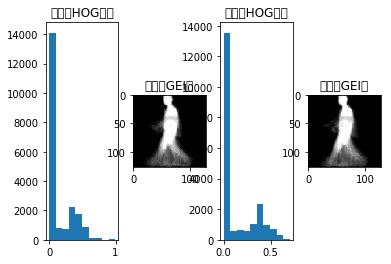

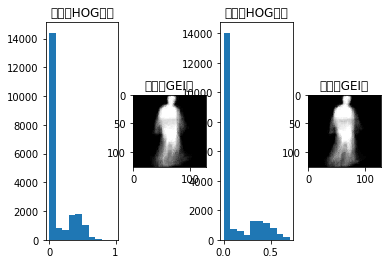

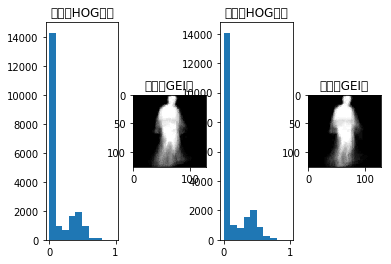

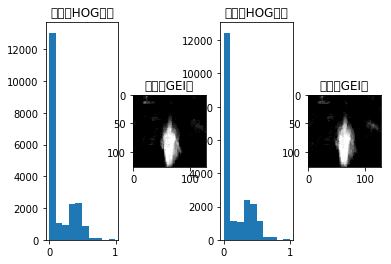

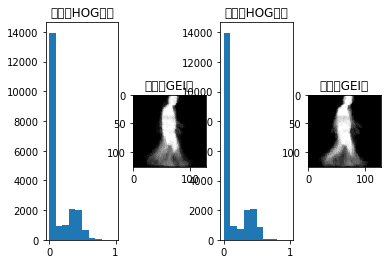

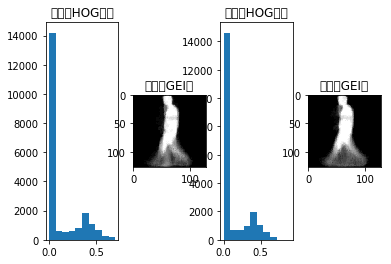

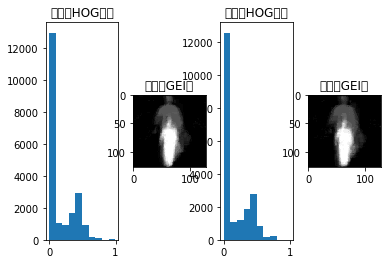

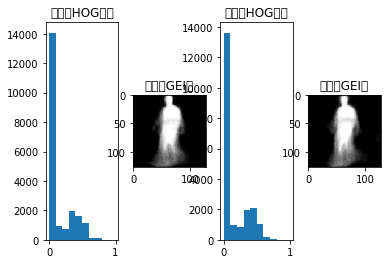

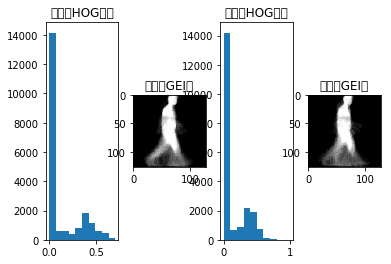

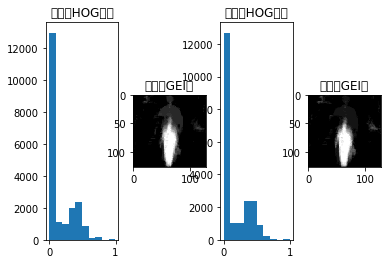

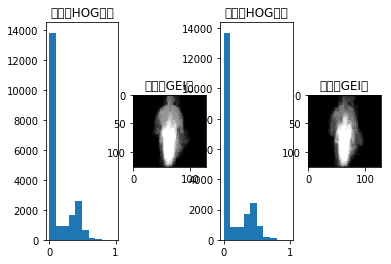

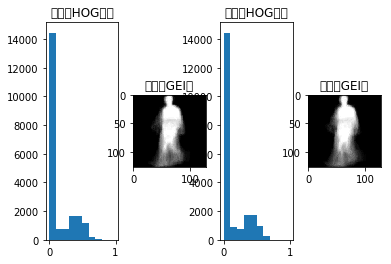

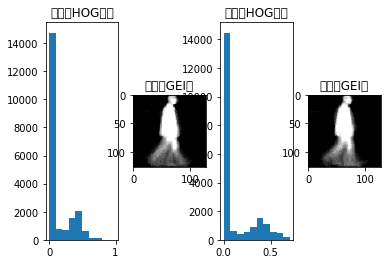

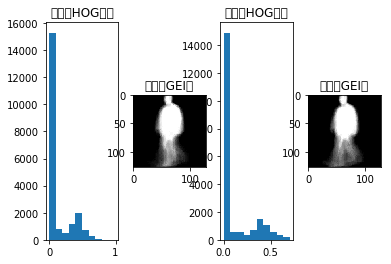

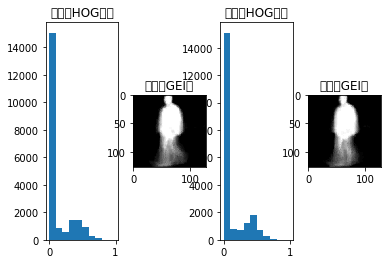

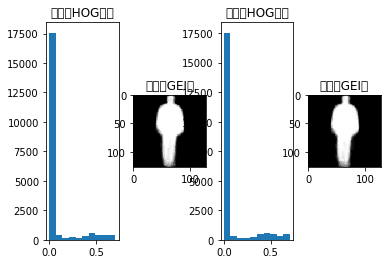

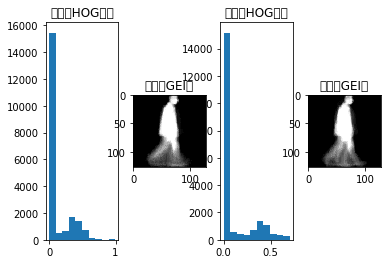

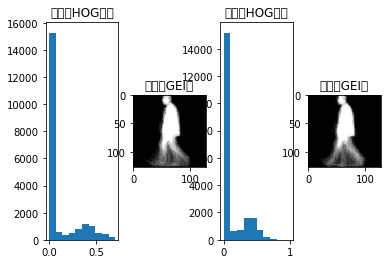

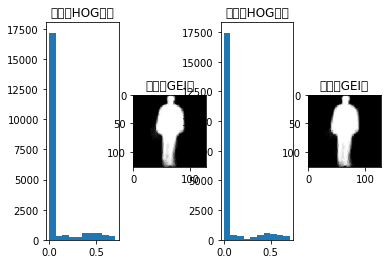

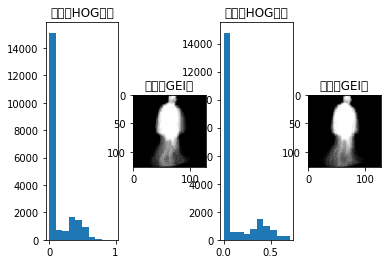

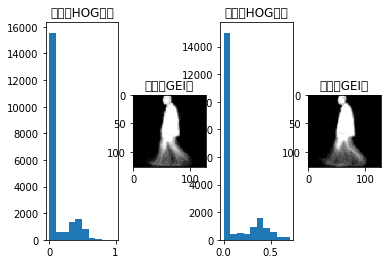

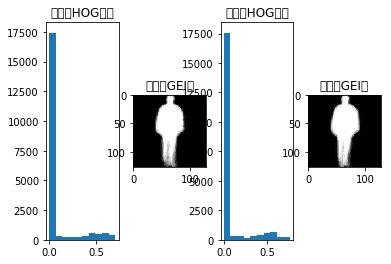

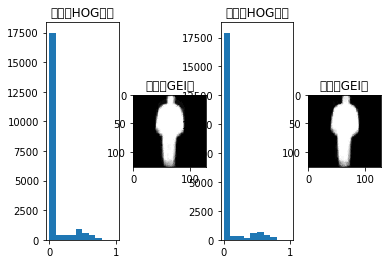

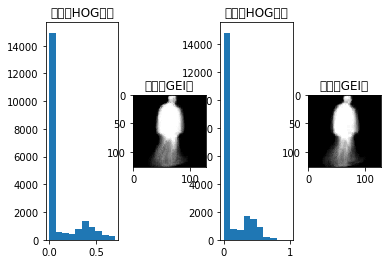

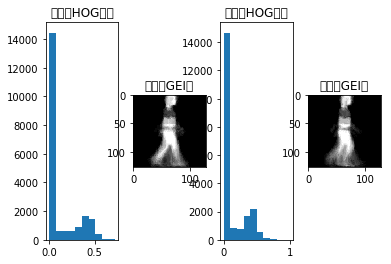

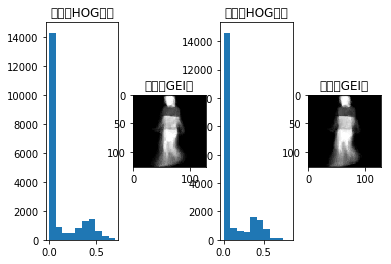

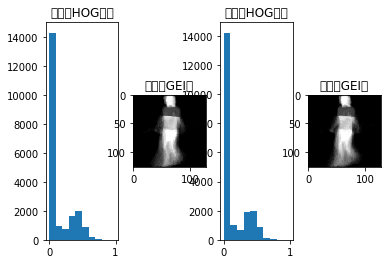

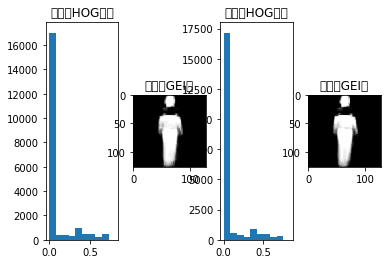

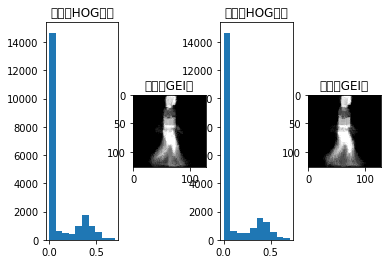

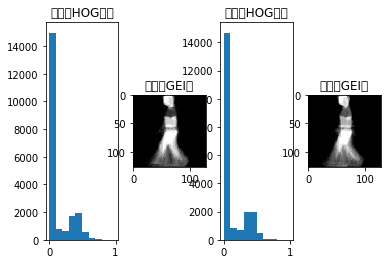

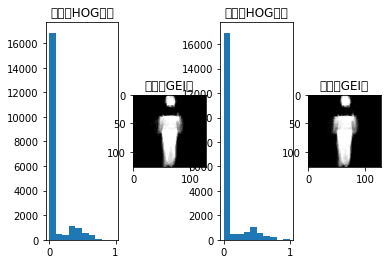

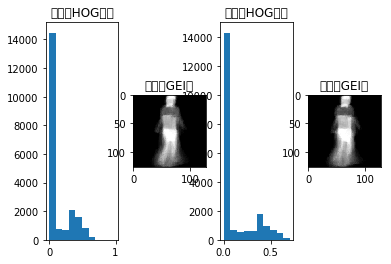

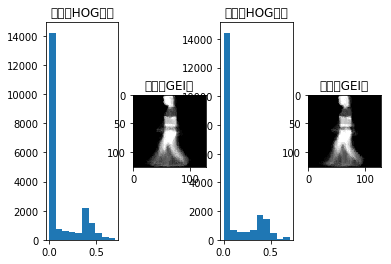

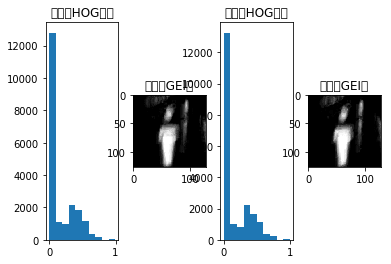

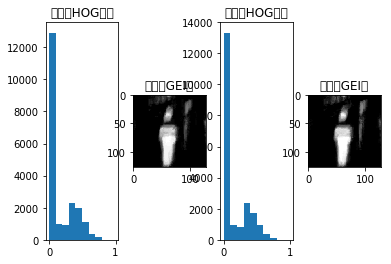

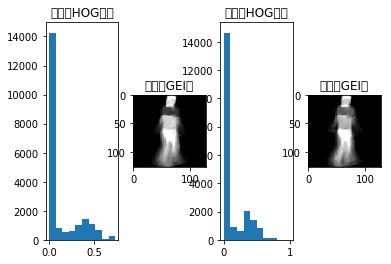

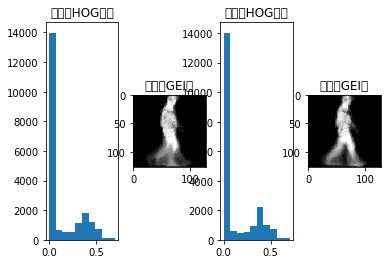

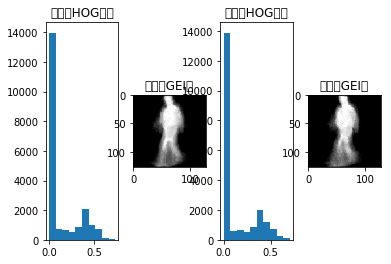

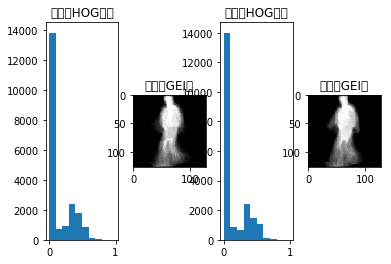

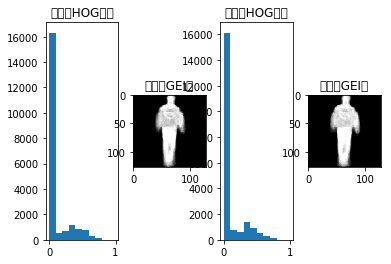

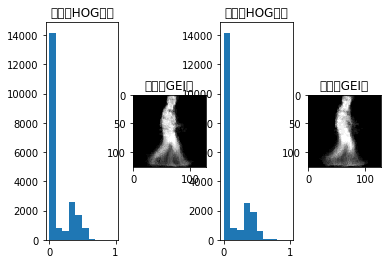

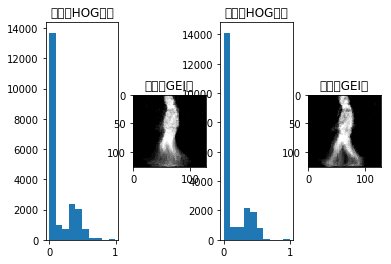

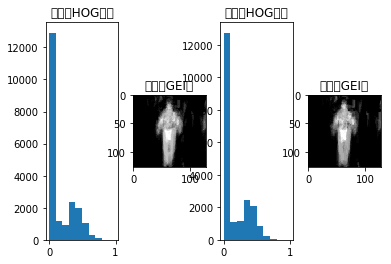

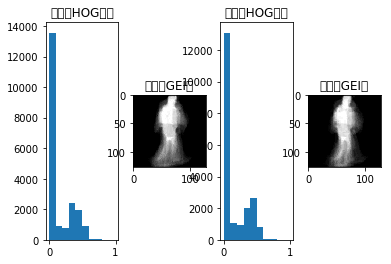

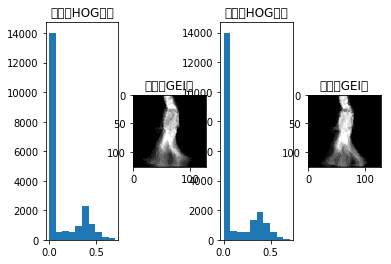

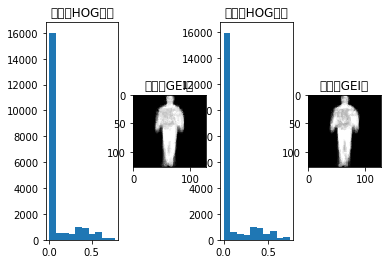

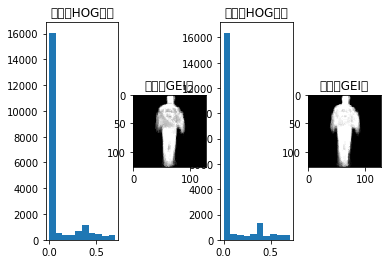

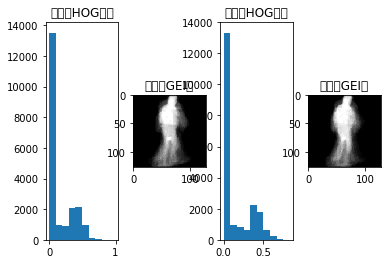

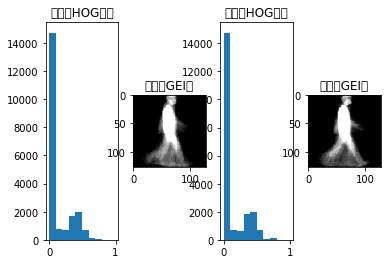

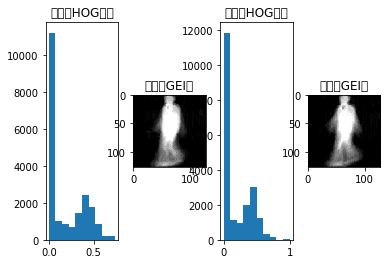

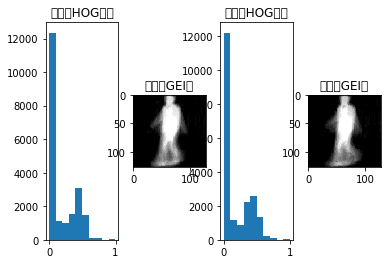

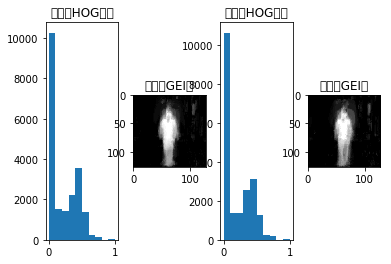

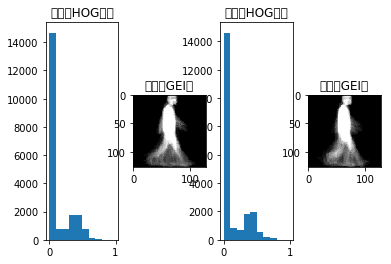

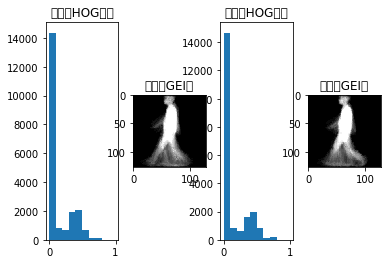

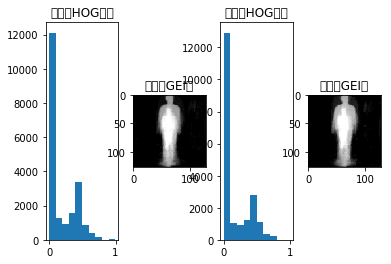

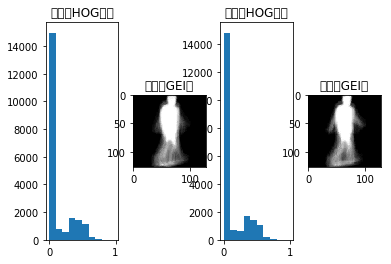

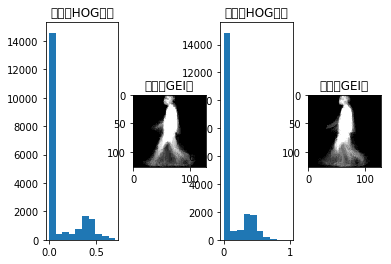

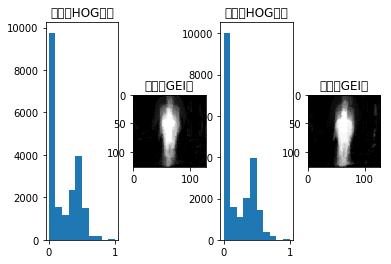

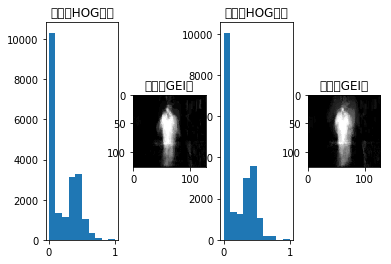

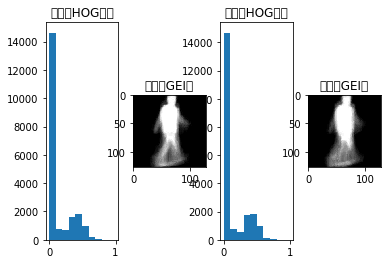

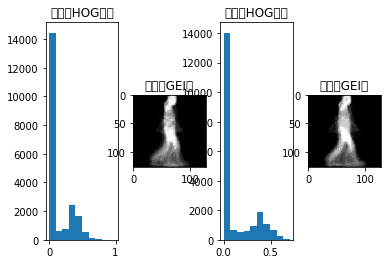

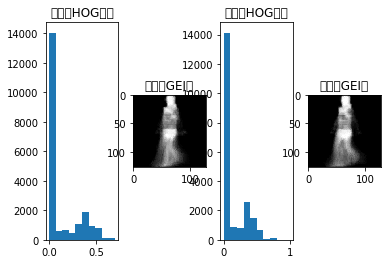

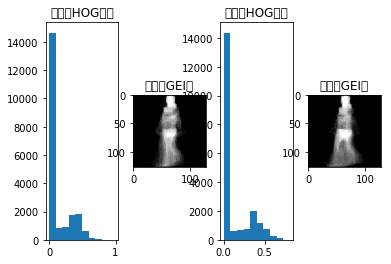

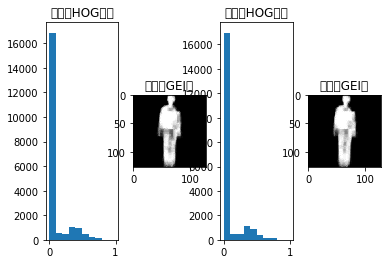

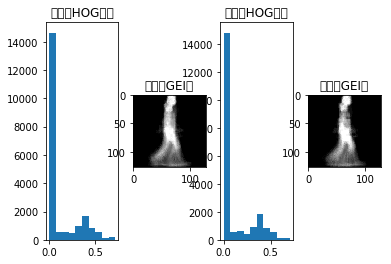

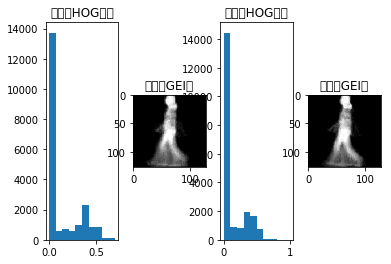

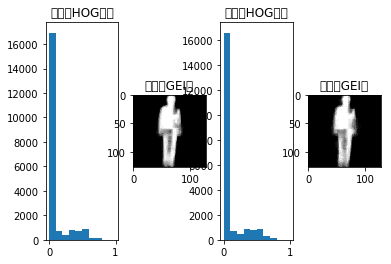

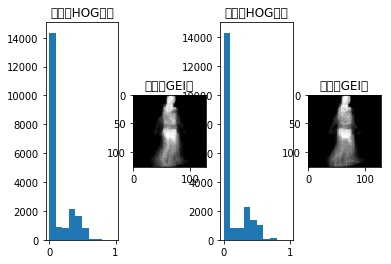

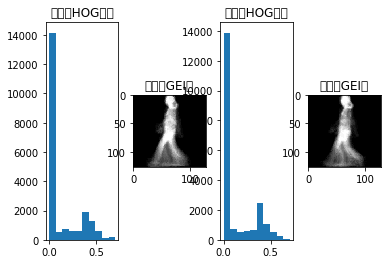

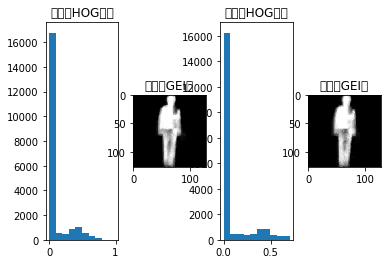

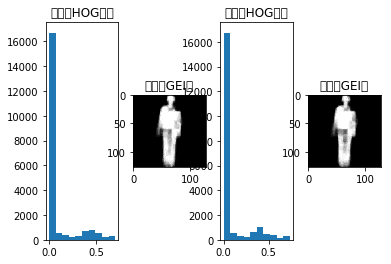

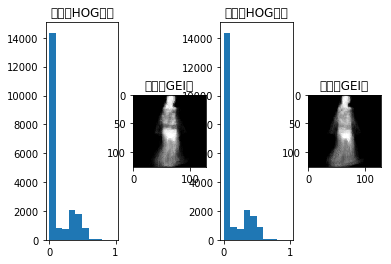

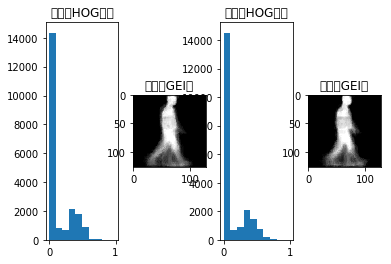

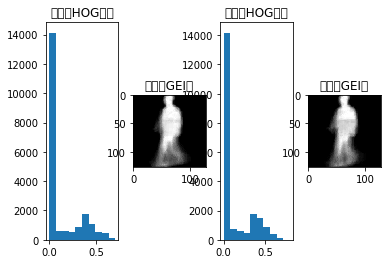

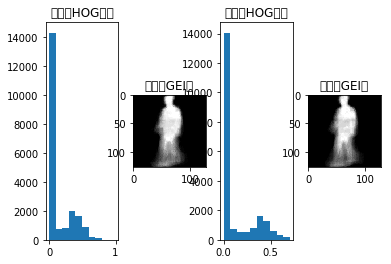

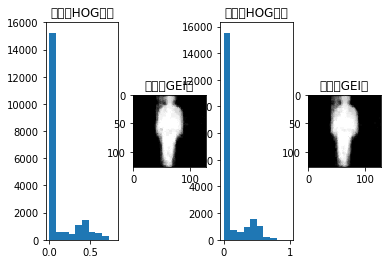

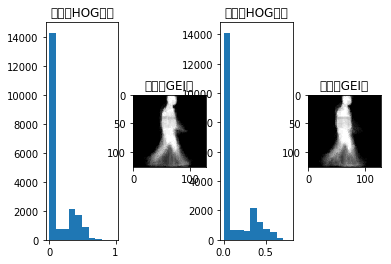

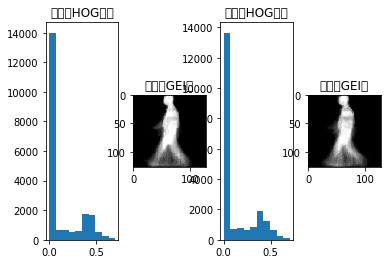

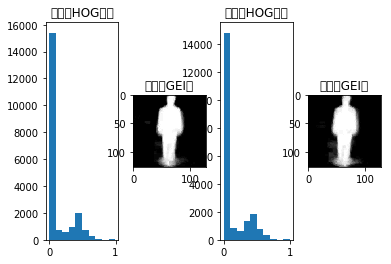

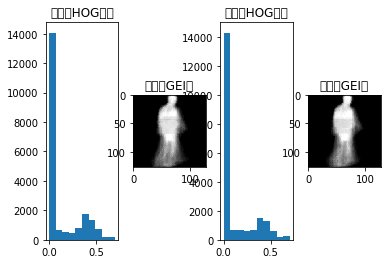

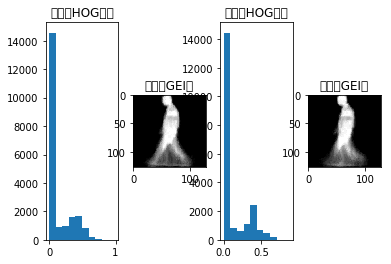

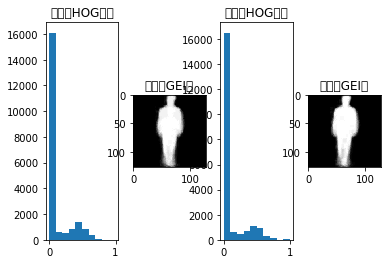

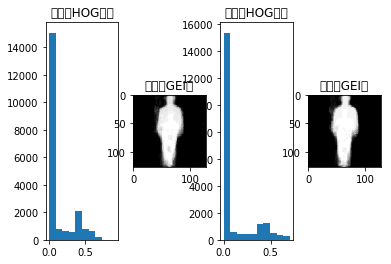

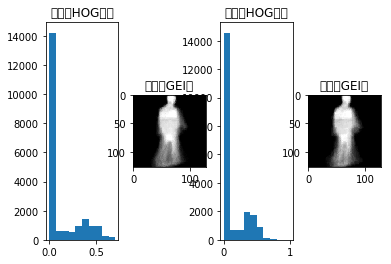

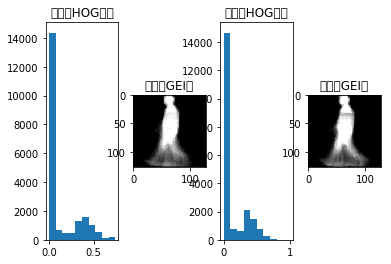

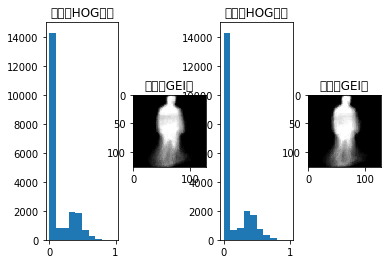

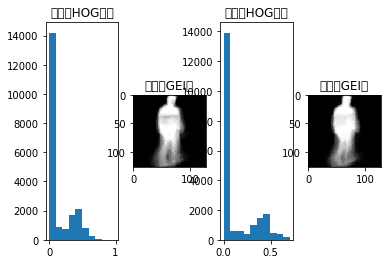

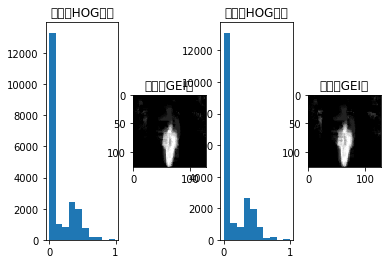

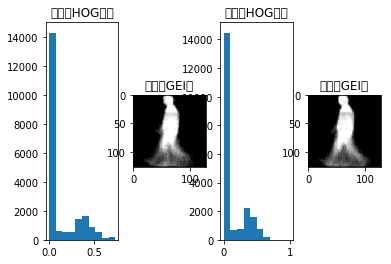

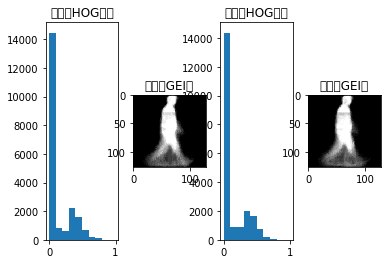

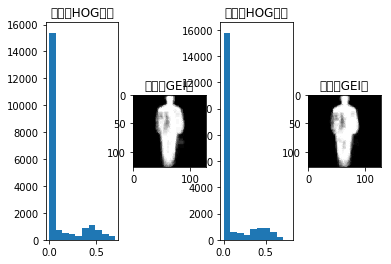

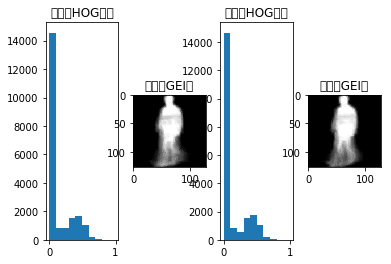

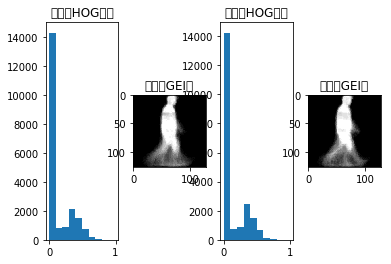

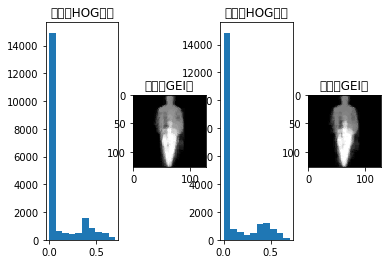

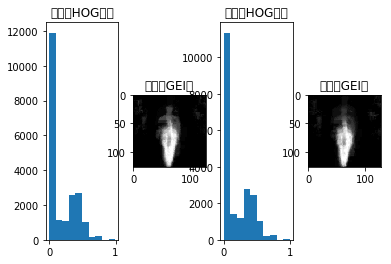

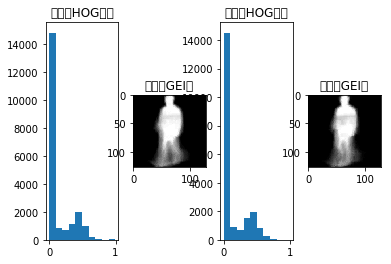

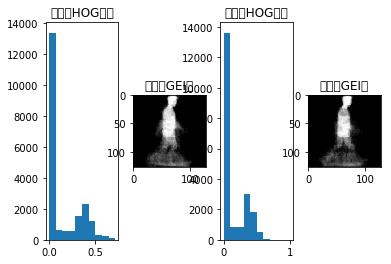

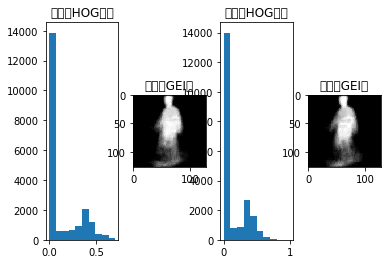

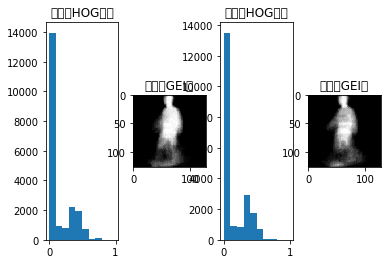

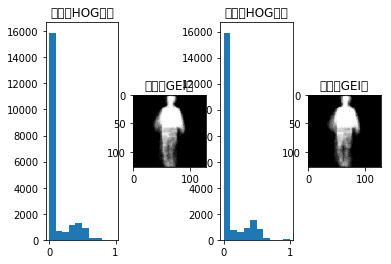

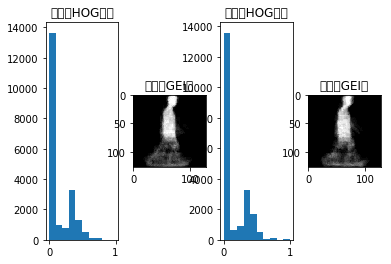

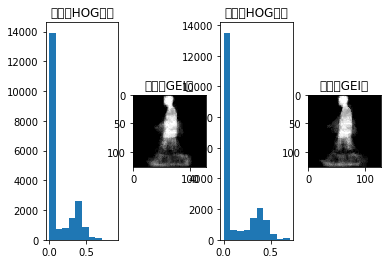

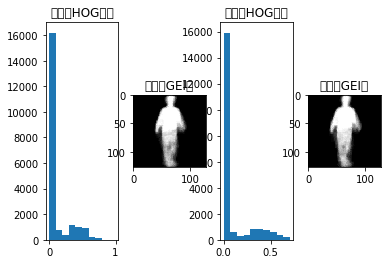

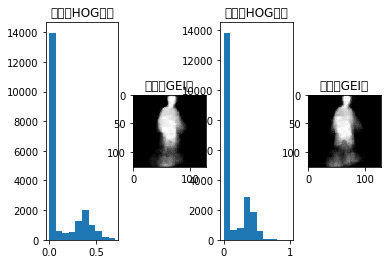

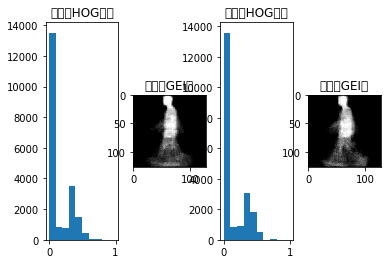

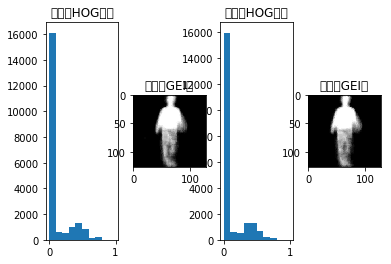

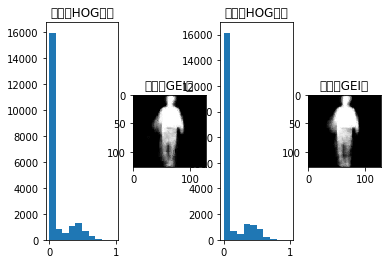

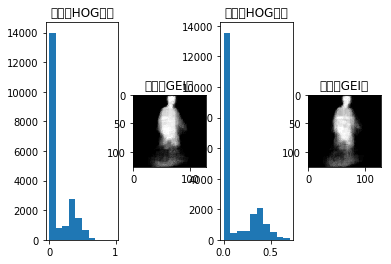

In [32]:
for i in range(len(trainhogs)):
    plt.subplot(141), plt.title("训练集HOG特征"),plt.hist(trainhogs[i])
    plt.subplot(142), plt.title("训练集GEI图"),plt.imshow(traingeis[i],cmap='gray')
    plt.subplot(143), plt.title("测试集HOG特征"),plt.hist(testhogs[i])
    plt.subplot(144), plt.title("测试集GEI图"),plt.imshow(testgeis[i],cmap='gray')
    plt.show()